In [1]:
%matplotlib inline
from collections import defaultdict
import pymc as pm
from pymc.Matplot import plot as mcplot
import numpy as np
from matplotlib import pyplot as plt
import json
from pymongo import MongoClient
import pymongo
from bson.objectid import ObjectId
import random

In [2]:
class grader(object):
    def __init__(self, name):
        self.name = name
        self.graded_handins = list()
        
    def grade_handin(self, handin):
        self.graded_handins.append(handin)

In [3]:
class bias_grader(grader):
    def __init__(self, name, bias_mean, bias_tau):
        super(bias_grader,self).__init__(name)
        self.bias_mean = bias_mean
        self.bias_tau = bias_tau
        self.distribution = pm.Normal('data_generator',bias_mean,bias_tau)
        
    def grade_handin(self, handin):
        super(bias_grader,self).grade_handin(handin)
        # take random number from a continues normal distribution where the expectd value is handin.true_score+bias_mean
        # and variance with bias_tau
        g_score = float(self.distribution.random())+handin.true_score
        while g_score < 0 or g_score > 1:
            g_score = float(self.distribution.random())+handin.true_score
        
        return g_score

In [4]:
class random_grader(grader):
    
    def __init__(self, name):
        super(random_grader,self).__init__(name)
        self.distribution = pm.Uniform('data_generator',0,1)
    
    def grade_handin(self, handin):
        super(random_grader,self).grade_handin(handin)
        # take random number from a continues uniform distribution in range [0,1]
        return self.distribution.random()

In [5]:
class true_grader(grader):
    
    def __init__(self,name):
        super(true_grader,self).__init__(name)
    
    def grade_handin(self, handin):
        super(true_grader,self).grade_handin(handin)
        return handin.true_score

In [6]:
class handin:
    
    def __init__(self,title,owner,true_score):
        self.title = title
        self.owner = owner
        self.true_score = true_score
        self.gradeings = dict()
    
    def add_gradeing(self,grader):
        self.gradeings[grader.name] = grader.grade_handin(self)

In [7]:
class assignment(object):
    
    def __init__(self, handins_input, graders_input):
        self.handins = dict()
        self.graders = dict()
        for handin in handins_input:
            self.handins[handin.title] = handin
        for grader in graders_input:
            self.graders[grader.name] = grader
    
    def add_handin(self, handin):
        self.handing[handin.title] = handin
        
    def add_grader(self, grader):
        self.graders[grader.title] = grader
    
    def find_ungraded_handin(self, grader):
        
        # sort the handins by the one with the least
        i = 0
        handin = sorted(self.handins.values(),key=lambda x: len(x.gradeings))[i]
        while (grader.name in handin.gradeings) or (handin.owner.name == grader.name):
            i += 1
            handin = sorted(self.handins.values(),key=lambda x: len(x.gradeings))[i]
        return handin
            
    def grade_handins(self):
        for i in xrange(0,5):
            for grader in self.graders.itervalues():
                h = self.find_ungraded_handin(grader)
                h.add_gradeing(grader)

In [8]:
true_data = pm.Uniform('true_value_generator',0,1)

### Test data for 100 true graders and handins

In [9]:
handins_data = list()
graders_data = list()

for i in xrange(0,100):
    g = true_grader('t_grader_%i' % i)
    h = handin('handin_%i' % i, g, true_data.random())
    graders_data.append(g)
    handins_data.append(h)
    
assignment_data_true = assignment(handins_data,graders_data)
assignment_data_true.grade_handins()

## Model

In [10]:
def handin_model(data):
    N_H = len(data)
    
    # Bias
    T = dict()
    B = dict()
    O = list()

    for h in range(0, N_H):
        h_id = data[h].title
        scores = data[h].gradeings.items()
        #(scores,h_id) = data[h]
        
        N_G = len(scores)
#        np.mean(map(lambda x:x[1],scores))
        T_mu = pm.Normal('T_mu_%s' % str(h_id),0.5,25)
        T[h_id] = pm.Normal('T_%s' % str(h_id), mu=T_mu, tau=100)
        
        for g in range(0, N_G):
            (g_id,val) = scores[g]
            #(val,g_id) = scores[g]
            if g_id not in B:
                B[g_id] = pm.Normal('B_%s' % str(g_id), mu=0, tau=1000) 
            O.append(pm.Normal('O_%(h)i_%(g)i' % {'h': h, 'g':g}, mu = T[h_id] + B[g_id], tau=100, observed=True, value=val))
        
            
    collection = [pm.Container(T),
                  pm.Container(O),
                  pm.Container(B)]
    
    model = pm.Model(collection)
    map_ = pm.MAP(model)
    map_.fit()
    return model

In [11]:
def execute_model(model):
    mcmc = pm.MCMC(model)
    mcmc.sample(5000,500)
    return mcmc

In [12]:
model_true = handin_model(assignment_data_true.handins.values())

In [13]:
mcmc_handin1_true = execute_model(model_true)

 [-----------------100%-----------------] 5000 of 5000 complete in 204.7 sec

In [14]:
mcmc_handin2_true = execute_model(model_true)

 [-----------------100%-----------------] 5000 of 5000 complete in 205.2 sec

In [15]:
mcmc_handin3_true = execute_model(model_true)

 [-----------------100%-----------------] 5000 of 5000 complete in 207.7 sec

In [16]:
mcmc_true = [mcmc_handin1_true,mcmc_handin2_true,mcmc_handin3_true]

In [17]:
def find_bias(assignment,mcmc,f):
    bias_abs = list()
    for g in assignment.graders.keys():
        bias_mean = f(mcmc.trace('B_%s' % str(g))[:])
        bias_abs.append((bias_mean,g))
    return bias_abs

In [18]:
def find_T(assignment,mcmc,f):
    bias = list()
    for h in assignment.handins.keys():
        bias_mean = f(mcmc.trace('T_%s' % str(h))[:])
        bias.append((bias_mean,h))
    return bias

In [19]:
def plot_mean_var(ax,assignment_data,mcmc_handins,find,numpy_func):
    # find the mean bias of the two runs
    bias_abs_1 = find(assignment_data, mcmc_handins[0], numpy_func)
    bias_abs_2 = find(assignment_data, mcmc_handins[1], numpy_func)
    bias_abs_3 = find(assignment_data, mcmc_handins[2], numpy_func)

    # Generate dict of the found values in each run for each grader

    compared = defaultdict(list)
    collected = list()
    collected = bias_abs_1[:]
    collected.extend(bias_abs_2[:])
    collected.extend(bias_abs_3[:])

    for (value, _id) in collected:
        compared[_id].append(value)

    sorted_list = compared.items()
    sorted_list.sort(key=lambda x: np.mean(x[1][:]))

    labels = list()
    for (_id, value) in sorted_list:
        name = _id
        labels.append(name)

    values = map(lambda x: x[1], sorted_list)
    plt.boxplot(values,0, vert=False, labels=labels)

    box = ax.get_position()
    ax.set_position([box.x0, box.y0,
                     box.width+0.45, box.height*5])
    plt.vlines(0, 0, 120, color="k", linestyles="--", lw=1)

    if find.func_name == "find_bias":
        plt.xlabel("%s value of the bias distributions of a grader" % numpy_func.func_name)
    else:
        plt.xlabel("%s value of the true score distributions of a grader" % numpy_func.func_name)

In [20]:
def get_values(assignment_data,mcmc_handins,find,numpy_func):
    # find the mean bias of the two runs
    bias_abs_1 = find(assignment_data, mcmc_handins[0], numpy_func)
    bias_abs_2 = find(assignment_data, mcmc_handins[1], numpy_func)
    bias_abs_3 = find(assignment_data, mcmc_handins[2], numpy_func)

    # Generate dict of the found values in each run for each grader

    compared = defaultdict(list)
    collected = list()
    collected = bias_abs_1[:]
    collected.extend(bias_abs_2[:])
    collected.extend(bias_abs_3[:])

    for (value, _id) in collected:
        compared[_id].append(value)

    sorted_list = compared.items()
    sorted_list.sort(key=lambda x: x[0])

    labels = map(lambda x: x[0], sorted_list)
    values = map(lambda x: np.mean(x[1]), sorted_list)
    
    return labels,values

### True graders plot

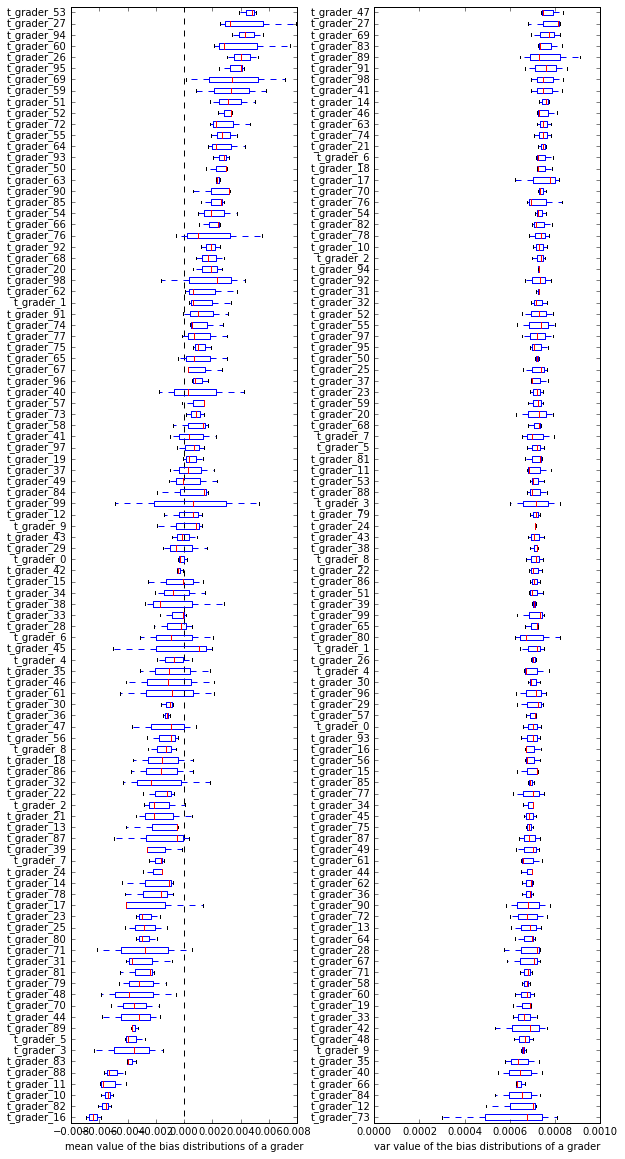

In [21]:
ax = plt.subplot(191)
plot_mean_var(ax,assignment_data_true,mcmc_true,find_bias,np.mean)
ax = plt.subplot(199)
plot_mean_var(ax,assignment_data_true,mcmc_true,find_bias,np.var)
plt.show()

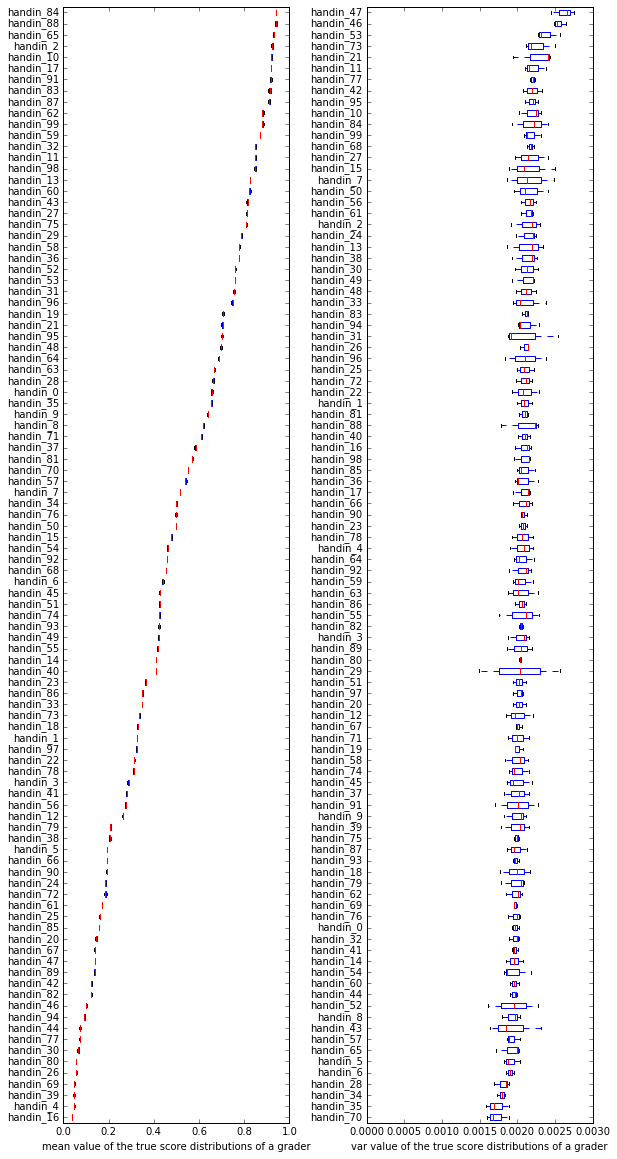

In [22]:
ax = plt.subplot(191)
plot_mean_var(ax,assignment_data_true,mcmc_true,find_T,np.mean)
ax = plt.subplot(199)
plot_mean_var(ax,assignment_data_true,mcmc_true,find_T,np.var)
plt.show()

### Test data for 100 bias graders

In [23]:
handins_data = list()
graders_data = list()

for i in xrange(0,100):
    g = bias_grader('b_grader_%i' % i, 0.02, 100)
    h = handin('handin_%i' % i, g, true_data.random())
    graders_data.append(g)
    handins_data.append(h)
    

assignment_data_bias = assignment(handins_data,graders_data)
assignment_data_bias.grade_handins()

In [24]:
model_bias = handin_model(assignment_data_bias.handins.values())

In [25]:
mcmc_handin1_bias = execute_model(model_bias)

 [-----------------100%-----------------] 5000 of 5000 complete in 3069.6 sec

In [26]:
mcmc_handin2_bias = execute_model(model_bias)

 [-----------------100%-----------------] 5000 of 5000 complete in 207.8 sec

In [27]:
mcmc_handin3_bias = execute_model(model_bias)

 [-----------------100%-----------------] 5000 of 5000 complete in 206.9 sec

In [28]:
mcmc_bias = [mcmc_handin1_bias,mcmc_handin2_bias,mcmc_handin3_bias]

### Bias plot

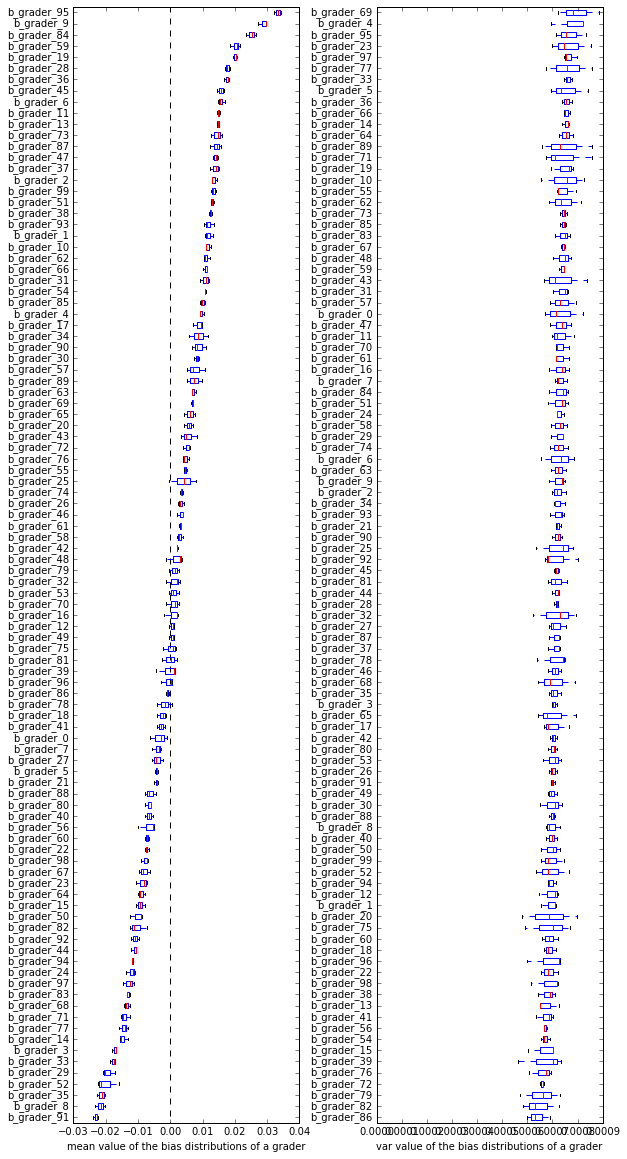

In [29]:
ax = plt.subplot(191)
plot_mean_var(ax,assignment_data_bias,mcmc_bias,find_bias,np.mean)
ax = plt.subplot(199)
plot_mean_var(ax,assignment_data_bias,mcmc_bias,find_bias,np.var)
plt.show()

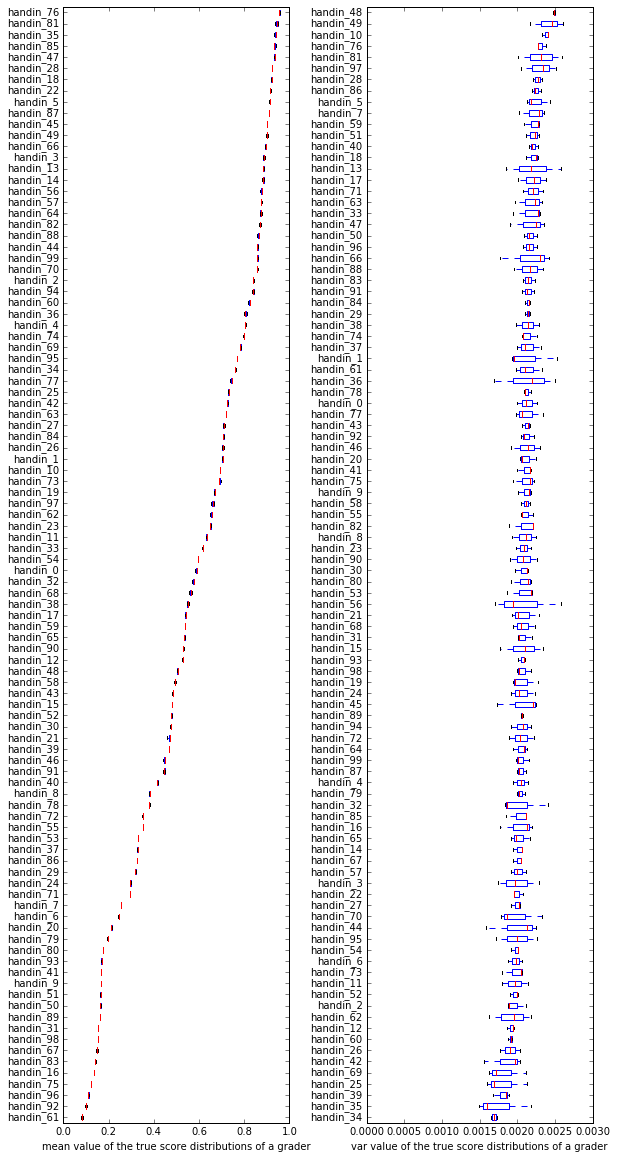

In [30]:
ax = plt.subplot(191)
plot_mean_var(ax,assignment_data_bias,mcmc_bias,find_T,np.mean)
ax = plt.subplot(199)
plot_mean_var(ax,assignment_data_bias,mcmc_bias,find_T,np.var)
plt.show()

### Test data for 100 random graders

In [31]:
handins_data = list()
graders_data = list()

for i in xrange(0,100):
    g = random_grader('r_grader_%i' % i)
    h = handin('handin_%i' % i, g, true_data.random())
    graders_data.append(g)
    handins_data.append(h)
    
assignment_data_random = assignment(handins_data,graders_data)
assignment_data_random.grade_handins()

In [32]:
model_random = handin_model(assignment_data_random.handins.values())

In [33]:
mcmc_handin1_random = execute_model(model_random)

 [-----------------100%-----------------] 5000 of 5000 complete in 207.9 sec

In [34]:
mcmc_handin2_random = execute_model(model_random)

 [-----------------100%-----------------] 5000 of 5000 complete in 206.3 sec

In [35]:
mcmc_handin3_random = execute_model(model_random)

 [-----------------100%-----------------] 5000 of 5000 complete in 1383.1 sec

In [36]:
mcmc_random = [mcmc_handin1_random,mcmc_handin2_random,mcmc_handin3_random]

### Random plot

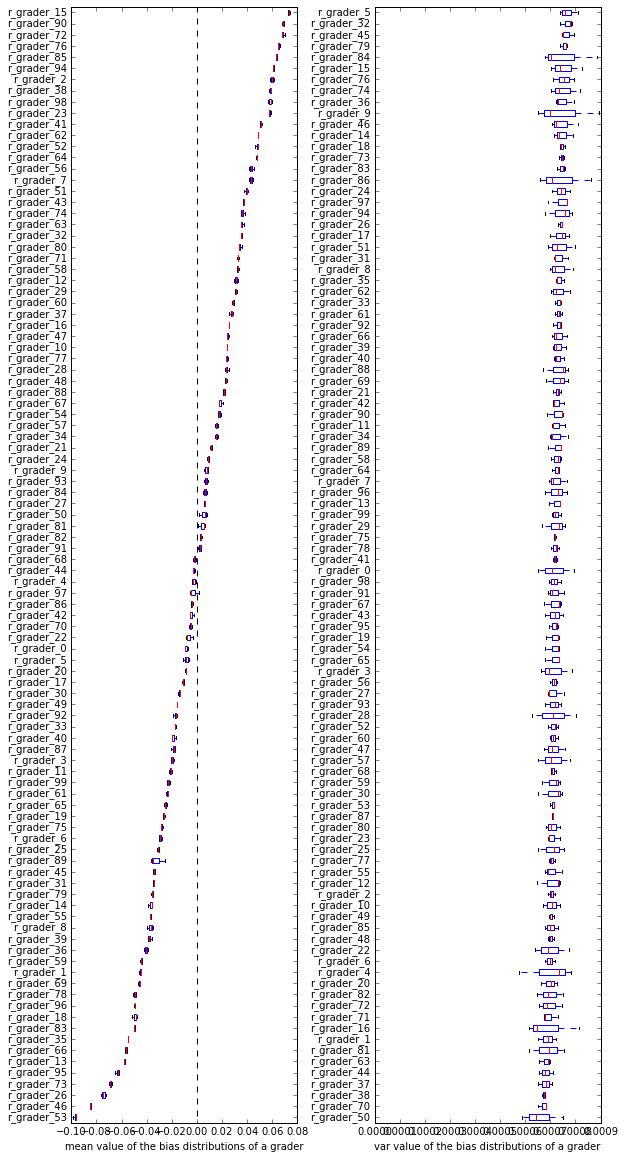

In [37]:
ax = plt.subplot(191)
plot_mean_var(ax,assignment_data_random,mcmc_random,find_bias,np.mean)
ax = plt.subplot(199)
plot_mean_var(ax,assignment_data_random,mcmc_random,find_bias,np.var)
plt.show()

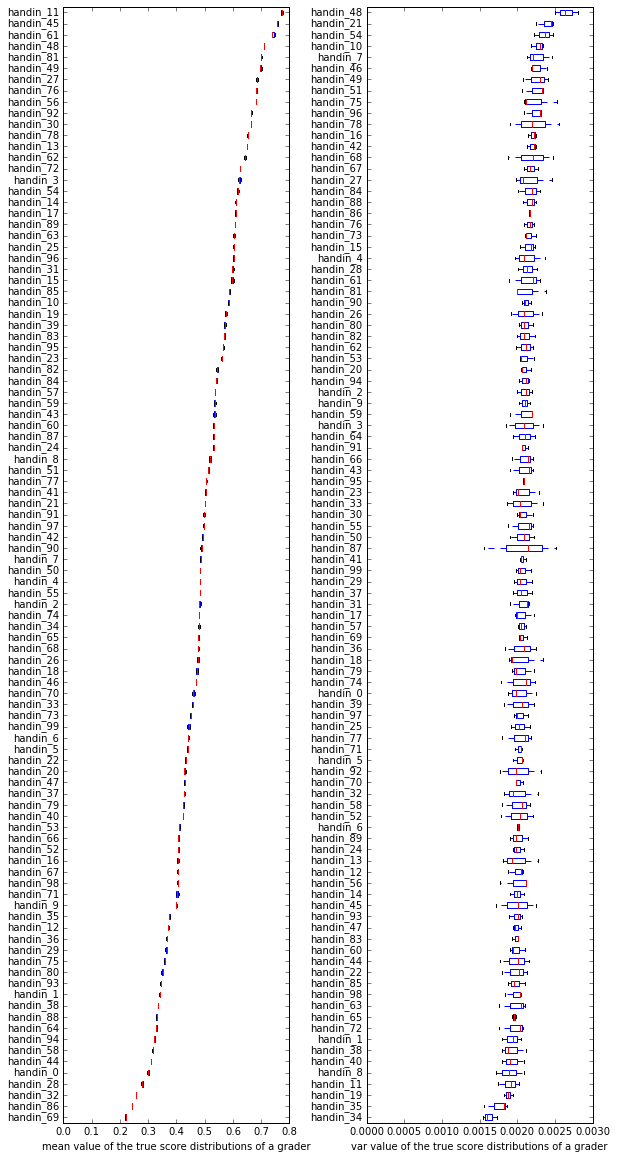

In [38]:
ax = plt.subplot(191)
plot_mean_var(ax,assignment_data_random,mcmc_random,find_T,np.mean)
ax = plt.subplot(199)
plot_mean_var(ax,assignment_data_random,mcmc_random,find_T,np.var)
plt.show()

## Mixed data

Next we can try to mix the three different grader types into one model and see how the result behaves

In [39]:
handins_data = list()
graders_data = list()

for i in xrange(0,33):
    g = random_grader('r_grader_%i' % i)
    h = handin('handin_%i' % i, g, true_data.random())
    graders_data.append(g)
    handins_data.append(h)
    
for i in xrange(33,67):
    g = bias_grader('b_grader_%i' % i, 0.02, 100)
    h = handin('handin_%i' % i, g, true_data.random())
    graders_data.append(g)
    handins_data.append(h)

for i in xrange(67,100):
    g = true_grader('t_grader_%i' % i)
    h = handin('handin_%i' % i, g, true_data.random())
    graders_data.append(g)
    handins_data.append(h)
    
assignment_data_mixed = assignment(handins_data,graders_data)
assignment_data_mixed.grade_handins()

In [40]:
model_mixed = handin_model(assignment_data_mixed.handins.values())

In [41]:
mcmc_handin1_mixed = execute_model(model_mixed)

 [-----------------100%-----------------] 5000 of 5000 complete in 205.0 sec

In [42]:
mcmc_handin2_mixed = execute_model(model_mixed)

 [-----------------100%-----------------] 5000 of 5000 complete in 207.4 sec

In [43]:
mcmc_handin3_mixed = execute_model(model_mixed)

 [-----------------100%-----------------] 5000 of 5000 complete in 331.0 sec

In [44]:
mcmc_mixed = [mcmc_handin1_mixed,mcmc_handin2_mixed,mcmc_handin3_mixed]

### Mixed data plot

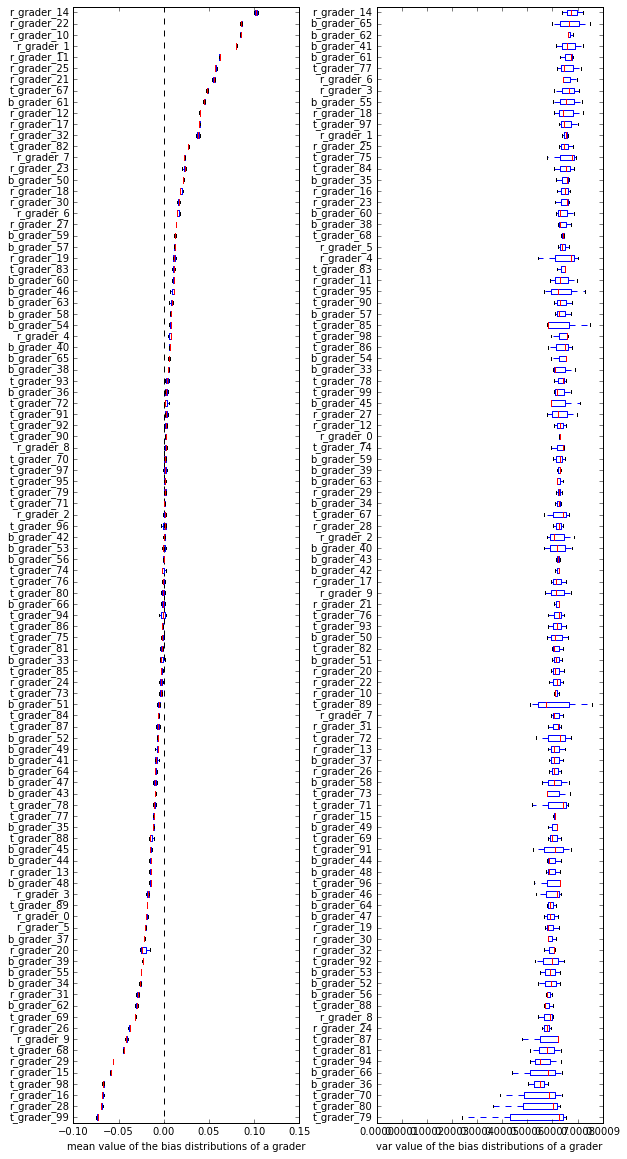

In [45]:
ax = plt.subplot(191)
plot_mean_var(ax,assignment_data_mixed,mcmc_mixed,find_bias,np.mean)
ax = plt.subplot(199)
plot_mean_var(ax,assignment_data_mixed,mcmc_mixed,find_bias,np.var)
plt.show()

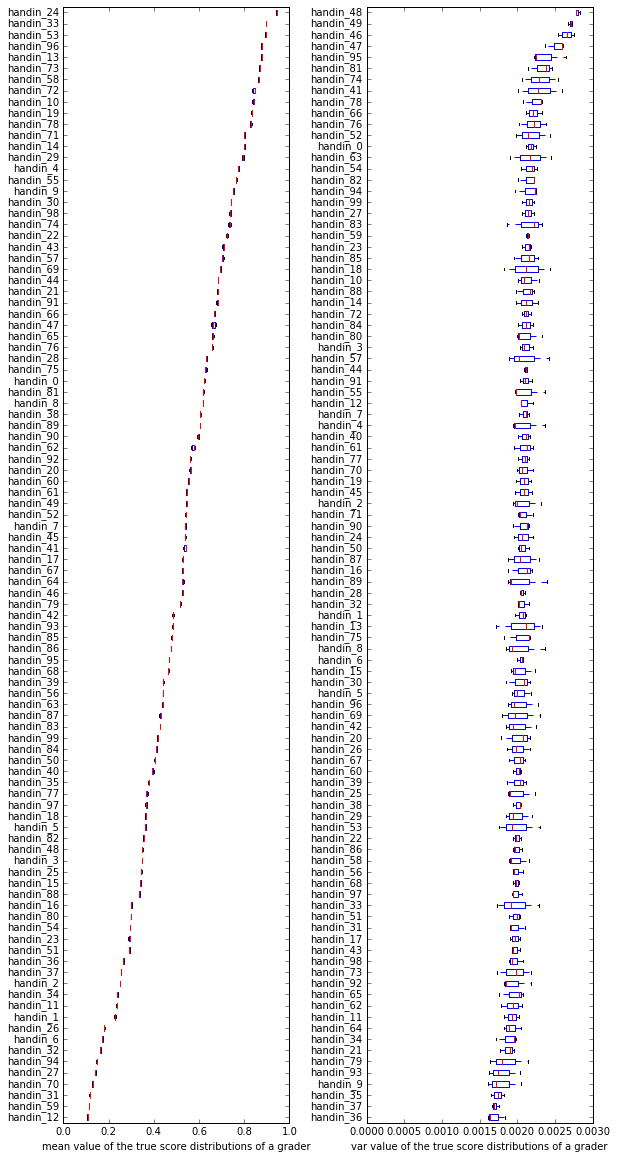

In [46]:
ax = plt.subplot(191)
plot_mean_var(ax,assignment_data_mixed,mcmc_mixed,find_T,np.mean)
ax = plt.subplot(199)
plot_mean_var(ax,assignment_data_mixed,mcmc_mixed,find_T,np.var)
plt.show()

##  Difference from the true score

In [47]:
def plot_diff():
#    assignements = [assignment_data_true]
#    mcmcs = [mcmc_true]

    assignements = [assignment_data_true,assignment_data_bias,assignment_data_random,assignment_data_mixed]
    mcmcs = [mcmc_true,mcmc_bias,mcmc_random,mcmc_mixed]
    color= ['r','g','b','m']
    legends = ['True','Bias','Random','Mixed']
    
    ax = plt.subplot(111)
    
    offset = 0
    pos = range(0,100)
    labels_y = list()
    
    for ind, (ass, mc) in enumerate(zip(assignements,mcmcs)):
        final_val = list()
        labels, values = get_values(ass,mc,find_T,np.mean)
        labels_y = labels
        for l, v in zip(labels,values):
            true_score = ass.handins[l].true_score
            final_val.append(true_score-v)
        pos_ = [x+offset for x in pos]
        ax.barh(pos_,final_val,0.2,align='center',color = color[ind],label=legends[ind])
        offset += 0.2
    
    box = ax.get_position()
    ax.set_position([box.x0, box.y0,
                     box.width*1.5, box.height*10])
    plt.yticks(map(lambda x: x + 0.5, pos),labels_y)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.99))
    plt.xlabel("The models difference from the true score of a handin")
    plt.ylabel("Handins")
    plt.ylim(0,100)
    plt.show()

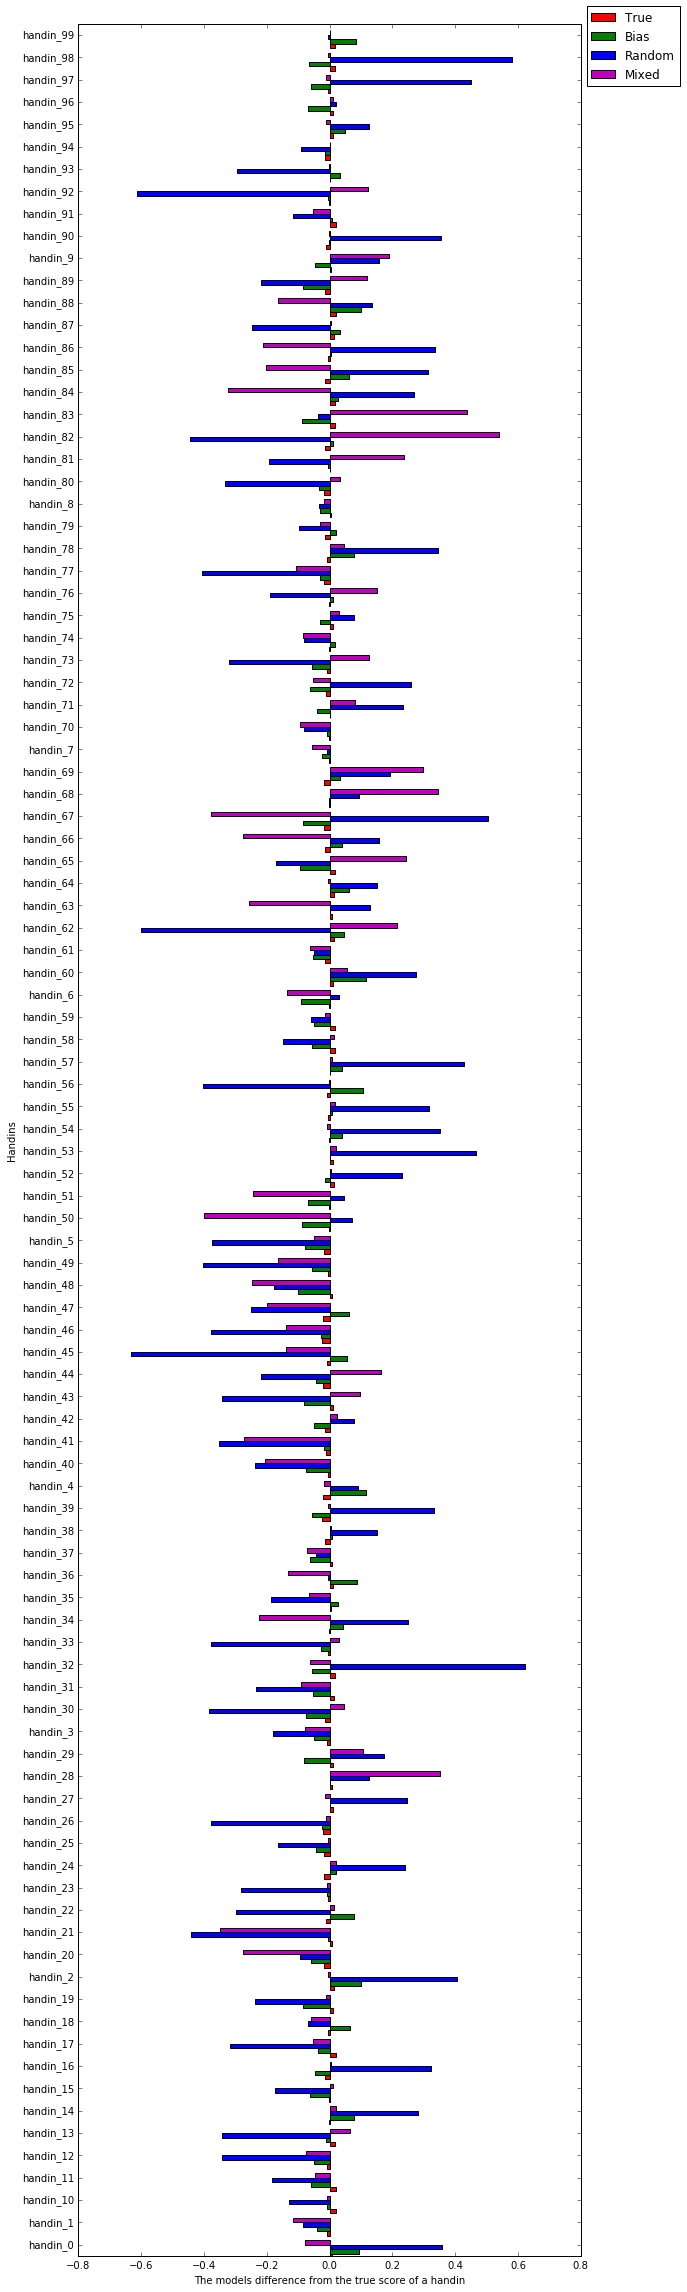

In [48]:
plot_diff()

In [49]:
assignment_data_mixed.handins['handin_81'].gradeings

{'r_grader_20': array(0.6372463339849169),
 'r_grader_21': array(0.19466127029918634),
 'r_grader_26': array(0.487692045768803),
 'r_grader_27': array(0.8671144816161592),
 'r_grader_29': array(0.87407360888848)}